In [1]:
from psg import PSG
import matplotlib.pyplot as plt
from importlib import reload
import numpy as np
import pandas as pd
import constants
from ecg import ECG
from emg import EMG
import eeg
from eeg import EEG
from eog import EOG
from sao2 import *
from matplotlib import pyplot as plt
from scipy import stats
import gc
import sklearn as sk
from sklearn import impute as skImpute
import seaborn as sns
from sklearn import preprocessing
from sklearn import metrics
from sklearn import neighbors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
from scipy import stats
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids

In [ ]:
training_set_1 = ['ins2', 'ins6', 'n11', 'n2']
training_set_2 = ['nfle10', 'nfle11', 'nfle12', 'nfle13', 'nfle14', 'nfle15']
training_set_3 = ['plm10', 'plm1', 'plm2', 'plm3', 'plm5', 'plm6']
training_set_4 = ['rbd10', 'rbd11', 'rbd12', 'rbd13', 'rbd16', 'rbd17']

testing_set_1 = ['ins8', 'ins9', 'n5'] 
testing_set_2 = ['nfle16', 'nfle17', 'nfle18', 'nfle19'] 
testing_set_3 = ['plm7', 'plm8', 'plm9']
testing_set_4 = ['rbd18', 'rbd19', 'rbd20']

# Make sure you have the edf and txt files for each individual along with the GitHub modules.

for i in training_set_2:
    psg_data = PSG(i)

    #EEG Feature Extraction
    reload(eeg)
    EEG_columns = eeg.EEG(psg_data.data)
    EEG_columns.extract_features()
    eeg_data = EEG_columns.eeg_features

    #SAO2 Feature Extraction
    oxyData = psg_data.data[['epoch','SAO2']]
    sao2_data = SAO2(oxyData).get_SAO2_metrics()

    #EOG Feature Extraction
    eog_data = EOG(psg_data.data).get_EOG_metrics()

    #EMG Feature Extraction
    sxDfInput = psg_data.data.loc[:, ["elapsed_seconds", "epoch", "SX1-SX2"]]
    sx = EMG(sxDfInput, signalType = "SX1-SX2")
    sx_data = sx.getMetrics()

    dxDfInput = psg_data.data.loc[:, ["elapsed_seconds", "epoch", "DX1-DX2"]]
    dx = EMG(dxDfInput, signalType = "DX1-DX2")
    dx_data = dx.getMetrics()

    emgDfInput = psg_data.data.loc[:, ["elapsed_seconds", "epoch", "EMG1-EMG2"]]
    emg_columns = EMG(emgDfInput)
    emg_data = emg_columns.getMetrics()

    #ECG Feature Extraction
    ecgDfInput = psg_data.data.loc[:, ["epoch", "ECG1-ECG2"]]
    ecg_columns = ECG(ecgDfInput)
    ecg_data = ecg_columns.getMetrics()

    plethDfInput = psg_data.data.loc[:, ["elapsed_seconds", "epoch", "PLETH"]]
    pleth = ECG(plethDfInput, signalType = 'PLETH')
    pleth_data = pleth.getMetrics()

    #Combine and Export Data
    stage_1 = pd.merge(psg_data.txtData, eeg_data, how = 'left', on='epoch')
    stage_2 = pd.merge(stage_1, sao2_data, how = 'left', on='epoch')
    stage_3 = pd.merge(stage_2, eog_data, how = 'left', on='epoch')
    stage_4 = pd.merge(stage_3, sx_data, how = 'left', on='epoch')
    stage_5 = pd.merge(stage_4, dx_data, how = 'left', on='epoch')
    stage_6 = pd.merge(stage_5, emg_data, how = 'left', on='epoch')
    stage_7 = pd.merge(stage_6, ecg_data, how = 'left', on='epoch')
    final = pd.merge(stage_7, pleth_data, how = 'left', on='epoch')

    final.to_csv(i+'.csv')
    print(i+" successfully exported!")


In [2]:
allData = ['nfle10', 'nfle11', 'nfle12', 'nfle13', 'nfle14', 'nfle15','plm10', 'plm1', 'plm2', 'plm3', 'plm5', 'plm6','rbd10', 'rbd11', 'rbd12', 'rbd13', 'rbd16', 'rbd17', 'ins2', 'ins6', 'n11', 'n2']
#allData = ['rbd10', 'rbd11', 'rbd12', 'rbd13', 'rbd16', 'rbd17']
#allData = ["n11", "n2", "ins2", "ins6"]
firstNumericCol = 6 # Includes age
filepath = 'final_data/'
final = pd.DataFrame()

for dataset in allData: # Stuff in the loop is done on each dataset individually before combining
    thisData = pd.read_csv(filepath + dataset + '.csv') # Create an untracked local data folder
    column_names = thisData.columns[firstNumericCol - 1:]

    # Add a patient column based on the file name so can be used to do groupby operations
    thisData.insert(1, "Patient", dataset)

    # Truncate based on shortest column before NaN's:
    lastNonNaNEachCol = thisData.notna()[::-1].idxmax()
    thisData = thisData.truncate(after = min(lastNonNaNEachCol))
    
    # Fill in missing data using KNN
    impute_KNN = thisData.iloc[:, firstNumericCol:]
    imputer = skImpute.KNNImputer(n_neighbors = 4, weights = "uniform")
    thisData.iloc[:, firstNumericCol:] = imputer.fit_transform(impute_KNN)

    # Combine with full dataset
    if final.empty:
        final = thisData
    else:
        final = pd.concat([final, thisData])
    
# Drop current "_norm" cols:
for col in final.columns:
    if "_norm" in col:
        final.drop(col, axis=1, inplace=True)

# Normalize (Divide by average within same patient):
for patient in final["Patient"].unique():
    thisPatientMeans = final[final["Patient"] == patient].iloc[:, firstNumericCol:].mean()
    final[final["Patient"] == patient].iloc[:, firstNumericCol:] /= thisPatientMeans
    
#Box-Cox
for column in final.columns[firstNumericCol:]:
    try:
        final[column] = final[column].abs()
        box_cox_trans = stats.boxcox(final[column])[0]
        final[column] = box_cox_trans
    except:
        continue
    #normalized = ((box_cox_trans-box_cox_trans.mean())/box_cox_trans.std())
    #final[column] = (box_cox_trans-box_cox_trans.min())/(box_cox_trans.max()-box_cox_trans.min())
    
print("Box-Cox completed.")  

#Robust Scaling
subset1 = final.iloc[:,:firstNumericCol]
subset2 = final.iloc[:,firstNumericCol:]

scaler = preprocessing.RobustScaler() # By default, centers and scales
robust_df = scaler.fit_transform(subset2)
final.iloc[:, firstNumericCol:] = robust_df
#robust_df = pd.DataFrame(robust_df, columns = column_names)
print("Robust Scaling completed.")

# Outlier Removal (Local Outlier Factor)
#keep_outliers = ['EMG']
n_neighbors = 20
LOF = neighbors.LocalOutlierFactor(n_neighbors = 20)
LOF.fit_predict(final.iloc[:, firstNumericCol:])
lof_factors = LOF.negative_outlier_factor_
final['lof'] = lof_factors
#outlierCutoff = -1000
quartiles = final['lof'].abs().quantile([0.25, 0.75])
#print(quartiles)
interQuartileRange = quartiles[0.75] - quartiles[0.25]
#outlierCutoff = -1 * (quartiles[0.75] + 1.5 * interQuartileRange)
outlierCutoff = -1000
outliers = final[final['lof'] <= outlierCutoff]
final = final[final['lof'] > outlierCutoff]
display(outliers)
#print(outlierCutoff)
#pd.DataFrame(lof_factors).to_csv('lof.csv')


#Encoding (Sleep Stage)
final.drop("Unnamed: 0", axis=1, inplace=True)

final.insert(2, "sleep_stage", np.zeros(len(final)))

for stage in constants.SLEEP_STAGES:
    final.loc[final["Sleep Stage"] == stage, "sleep_stage"] = constants.SLEEP_STAGES.get(stage)

final.drop("Sleep Stage", axis=1, inplace=True)

# Encoding (Condition)
conditionColumns = pd.DataFrame()
for patient in pd.unique(final['Patient']):
    thisPatientSeries = (final[final['Patient'] == patient])["condition"]
    thisPatientDf = thisPatientSeries.to_frame("condition")
    for condition in constants.CONDITION_TO_BINARY:
        if condition == thisPatientDf.at[0, 'condition']:
            binary = constants.CONDITION_TO_BINARY.get(condition)

            if binary[0] == 0:
                thisPatientDf.insert(1, "condition_0", np.zeros(len(thisPatientDf)))
            else:
                thisPatientDf.insert(1, "condition_0", np.ones(len(thisPatientDf)))

            if binary[1] == 0:
                thisPatientDf.insert(2, "condition_1", np.zeros(len(thisPatientDf)))
            else:
                thisPatientDf.insert(2, "condition_1", np.ones(len(thisPatientDf)))

            if binary[2] == 0:
                thisPatientDf.insert(3, "condition_2", np.zeros(len(thisPatientDf)))
            else:
                thisPatientDf.insert(3, "condition_2", np.ones(len(thisPatientDf)))

            if binary[3] == 0:
                thisPatientDf.insert(4, "condition_3", np.zeros(len(thisPatientDf)))
            else:
                thisPatientDf.insert(4, "condition_3", np.ones(len(thisPatientDf)))
    
    if conditionColumns.empty:
        conditionColumns = thisPatientDf[["condition_0", "condition_1", "condition_2", "condition_3"]]
    else: # ConditionColumns already initialized
        conditionColumns = pd.concat([conditionColumns, thisPatientDf[["condition_0", "condition_1", "condition_2", "condition_3"]]])
final.insert(5, "rbd", conditionColumns["condition_0"])
final.insert(6, "ins", conditionColumns["condition_1"])
final.insert(7, "nfle", conditionColumns["condition_2"])
final.insert(8, "plm", conditionColumns["condition_3"])

final.drop("condition", axis=1, inplace=True)

print('Encoding completed.')


#Robust Scaling
#subset1 = final.iloc[:,:firstNumericCol]
#subset2 = final.iloc[:,firstNumericCol:]

#scaler = preprocessing.RobustScaler() # By default, centers and scales
#robust_df = scaler.fit_transform(subset2)
#robust_df = pd.DataFrame(robust_df, columns = column_names)
#print("Robust Scaling done for " + dataset)

#Export
#final = pd.concat([subset1, robust_df], axis = 1)
final.reset_index(inplace=True)
final = final.iloc[:,1:]
final.to_csv('final.csv')
print('Dataset successfully exported!')

/Users/josh/opt/miniconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1851: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)
/Users/josh/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Box-Cox completed.
Robust Scaling completed.


,Unnamed: 0,Patient,epoch,Sleep Stage,condition,gender,age,beta_relative_power,alpha_relative_power,theta_relative_power,...,hf_ECG1-ECG2,lf/hf_ECG1-ECG2,breathingrate_ECG1-ECG2,bpm_PLETH,rmssd_PLETH,lf_PLETH,hf_PLETH,lf/hf_PLETH,breathingrate_PLETH,lof
335,335,nfle10,335,S2,Nocturnal Frontal Lobe Epilepsy,M,-1.134725,0.512983,-0.311239,0.066692,...,-1.651187e-01,0.895063,-1.000000,0.307469,-1.195462,2.484663e+30,1.761846e+30,0.582583,-0.666667,-1.167698e+04
374,374,nfle10,374,R,Nocturnal Frontal Lobe Epilepsy,M,-1.134725,0.786713,-0.108295,-0.164073,...,1.060420e+44,-0.154530,-0.333333,0.205755,-0.806286,-1.022664e-01,-4.731065e-01,0.612254,-0.333333,-1.472558e+43
387,387,nfle10,387,R,Nocturnal Frontal Lobe Epilepsy,M,-1.134725,0.311989,0.022207,-0.017049,...,1.231651e+00,-0.180223,-0.333333,0.113851,-0.928082,8.520675e+41,8.069072e+41,0.169167,-0.666667,-1.819148e+12
404,404,nfle10,404,S2,Nocturnal Frontal Lobe Epilepsy,M,-1.134725,0.442653,0.191422,0.558389,...,4.163326e-02,0.511632,0.000000,0.463773,-0.511146,8.249882e+27,4.246108e+28,-0.836300,-0.333333,-3.980369e+03
218,218,nfle11,218,S4,Nocturnal Frontal Lobe Epilepsy,M,-0.760055,0.123509,-0.288444,0.002967,...,1.658626e+27,-0.097259,-0.333333,0.449864,-0.352746,-2.222724e-01,-1.702086e-01,-0.095714,1.333333,-4.762168e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,120,n2,120,S2,Normal,M,-0.667102,0.177451,0.498567,0.187394,...,-2.715279e-01,-0.340795,0.974639,0.166269,0.481684,4.475632e+37,9.509977e+37,-0.513855,-0.666667,-7.679937e+08
576,576,n2,576,S4,Normal,M,-0.667102,-0.960747,-1.173838,-0.706286,...,-2.715279e-01,0.387723,0.773221,0.122010,0.530382,3.358503e+33,5.786033e+34,-0.995284,0.000000,-1.247121e+06
641,641,n2,641,R,Normal,M,-0.667102,0.565223,1.023624,0.804037,...,5.378924e+27,-0.383440,0.333333,-0.930361,-1.121076,5.094444e+00,3.850705e+00,0.373242,0.172304,-3.977299e+06
684,684,n2,684,S1,Normal,M,-0.667102,0.332315,0.071602,0.616733,...,5.085473e+36,-0.295537,0.333333,0.221636,0.554352,-1.903010e-01,1.487683e+00,-0.704621,1.333333,-6.563715e+12


Encoding completed.
Dataset successfully exported!


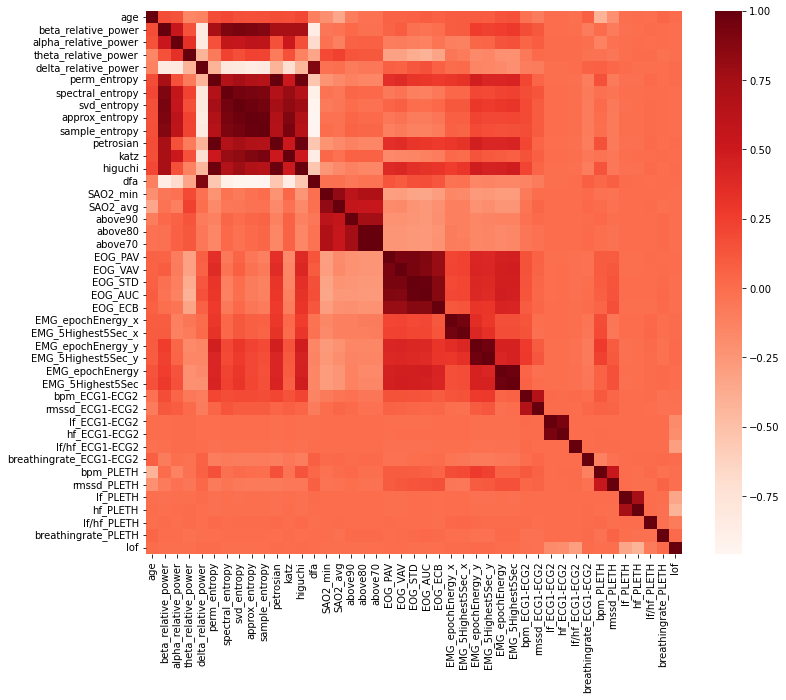

<ipython-input-3-a9905d1b9c6b>:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lowerTriangleMask = np.tril(np.ones(cor.shape), -1).astype(np.bool) # Create lower triangle mask


                Feature A             Feature B      Corr
50              petrosian          perm_entropy  0.999746
170               above70               above80  0.998866
44         sample_entropy        approx_entropy  0.990261
252               EOG_AUC               EOG_STD  0.986961
76                higuchi             petrosian  0.978670
71                higuchi          perm_entropy  0.976251
35         approx_entropy           svd_entropy  0.973806
434      EMG_5Highest5Sec       EMG_epochEnergy  0.969433
377    EMG_5Highest5Sec_y     EMG_epochEnergy_y  0.964968
86                    dfa        approx_entropy  0.958932
324    EMG_5Highest5Sec_x     EMG_epochEnergy_x  0.952047
27            svd_entropy      spectral_entropy  0.949293
43         sample_entropy           svd_entropy  0.947402
87                    dfa        sample_entropy  0.946222
85                    dfa           svd_entropy  0.938953
229               EOG_STD               EOG_PAV  0.937954
230           

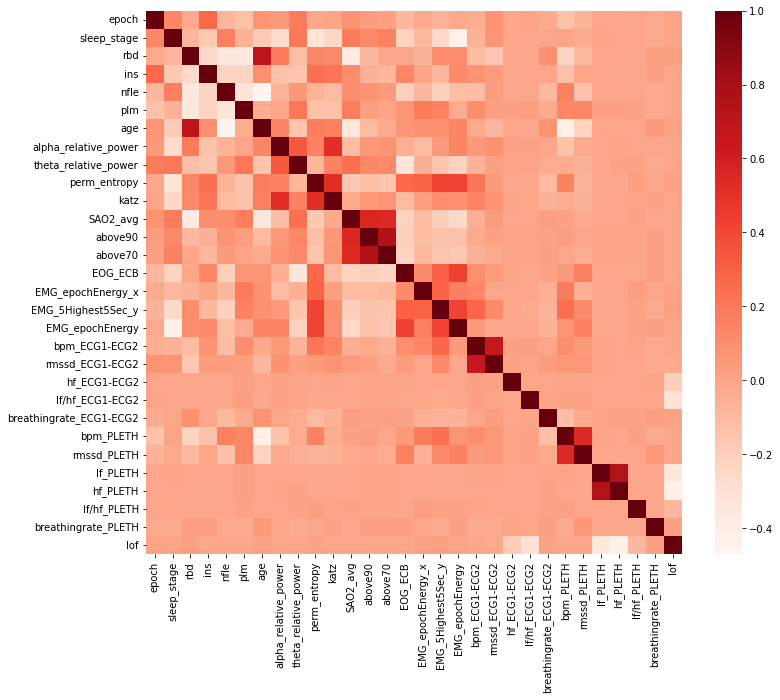

In [3]:
# Feature Removal Based on Between-Feature Correlation:

## INPUTS ##:
threshold = 0.8 # Abs correlation above which feature is removed

# 1. Calculate Correlation Matrix of the Predictors
columnsToCorr = list(final.columns)
safeFeatures = ['Patient', 'epoch', 'sleep_stage', 'rbd', 'ins', 'nfle', 'plm'] # Features that we won't remove
for i in safeFeatures:
    columnsToCorr.remove(i)

plt.figure(figsize=(12,10))
cor = final[columnsToCorr].corr()
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
plt.show()

# 2. Determine the two predictors associated with the largest absolute pairwise correlation
# Remove (set = 0) half of the matrix because symmetric:
lowerTriangleMask = np.tril(np.ones(cor.shape), -1).astype(np.bool) # Create lower triangle mask
corLowerTriangle = cor.where(lowerTriangleMask)
corAbs = corLowerTriangle.abs() # Consider absolute correlation

# Build sorted dataframe of form: ["Feature A", "Feature B", corr]
pairwiseCorr = corAbs.stack().reset_index()
pairwiseCorr.columns = ['Feature A','Feature B','Corr']

# Isolate correlations to remove
pairwiseCorr = pairwiseCorr[pairwiseCorr['Corr'] > threshold]
pairwiseCorr.sort_values('Corr', ascending = False, inplace = True)
print(pairwiseCorr)

# 3. Determine the average correlation between A and B and every other feature:
# Create an average correlation dataframe of form [feature, averageCorr]
averageCorr = pd.DataFrame(cor.abs().mean(axis = 1), cor.index, ['avgCorr'])

# Loop through pairwiseCorr, make a list of features to remove. 
featuresToRemove = []
for index, row in pairwiseCorr.iterrows():
    featureA = row['Feature A']
    featureB = row['Feature B']
    featureA_avgCorr = averageCorr.loc[featureA, 'avgCorr']
    featureB_avgCorr = averageCorr.loc[featureB, 'avgCorr']

    # If A has larger average correlation, remove it. Otherwise, remove B
    if featureA_avgCorr >= featureB_avgCorr:
        if featureA not in featuresToRemove:
            featuresToRemove.append(featureA)
    else:
        if featureB not in featuresToRemove:
            featuresToRemove.append(featureB)

# Report results:
print("Threshold: " + str(threshold))
print(featuresToRemove)

# Dataset with features removed
correlationFeatureRemoval = final.drop(featuresToRemove, axis = 1)
print("Remaining Features: " + str(correlationFeatureRemoval.shape[1]))

# Show the correlation matrix after feature removal
plt.figure(figsize=(12,10))
cor2 = correlationFeatureRemoval.corr()
sns.heatmap(cor2, annot=False, cmap=plt.cm.Reds)
plt.show()
    

In [4]:
print(averageCorr)
print(averageCorr.loc["above70", "avgCorr"])

                          avgCorr
age                      0.133090
beta_relative_power      0.283011
alpha_relative_power     0.199149
theta_relative_power     0.171625
delta_relative_power     0.260308
perm_entropy             0.319942
spectral_entropy         0.283221
svd_entropy              0.297562
approx_entropy           0.290262
sample_entropy           0.286279
petrosian                0.320592
katz                     0.254763
higuchi                  0.327787
dfa                      0.280387
SAO2_min                 0.193503
SAO2_avg                 0.169503
above90                  0.156082
above80                  0.167013
above70                  0.166701
EOG_PAV                  0.247356
EOG_VAV                  0.247965
EOG_STD                  0.254188
EOG_AUC                  0.254286
EOG_ECB                  0.219625
EMG_epochEnergy_x        0.149580
EMG_5Highest5Sec_x       0.159408
EMG_epochEnergy_y        0.250094
EMG_5Highest5Sec_y       0.236725
EMG_epochEnerg

In [5]:
# Feature Selection with Mutual Information

info_selection = pd.concat([correlationFeatureRemoval['sleep_stage'], correlationFeatureRemoval.iloc[:, 9:]], axis=1)

safe_features = list(correlationFeatureRemoval.iloc[:, :9].columns)

info_scores = []

for x in info_selection.columns[1:]:
    score = metrics.normalized_mutual_info_score(info_selection['sleep_stage'], info_selection[x])
    column_and_score = (x, score)
    info_scores.append(column_and_score)
    
target_columnscore = pd.DataFrame(info_scores).sort_values(by=1, ascending = False)

top_5_cols = safe_features+list(target_columnscore[0][:5])
top_10_cols = safe_features+list(target_columnscore[0][:10])
top_20_cols = safe_features+list(target_columnscore[0][:20])
top_30_cols = safe_features+list(target_columnscore[0][:30])

top_5_data = correlationFeatureRemoval[top_5_cols]
top_10_data = correlationFeatureRemoval[top_10_cols]
top_20_data = correlationFeatureRemoval[top_20_cols]
top_30_data = correlationFeatureRemoval[top_30_cols]

print(target_columnscore)

/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous 

                          0         1
8         EMG_epochEnergy_x  0.280823
0      alpha_relative_power  0.280821
9        EMG_5Highest5Sec_y  0.280821
2              perm_entropy  0.280821
3                      katz  0.280821
1      theta_relative_power  0.280821
10          EMG_epochEnergy  0.280821
7                   EOG_ECB  0.280821
17              rmssd_PLETH  0.280787
22                      lof  0.280756
19                 hf_PLETH  0.280705
16                bpm_PLETH  0.279828
20              lf/hf_PLETH  0.279490
18                 lf_PLETH  0.279342
12          rmssd_ECG1-ECG2  0.278684
11            bpm_ECG1-ECG2  0.275803
13             hf_ECG1-ECG2  0.274035
14          lf/hf_ECG1-ECG2  0.269590
15  breathingrate_ECG1-ECG2  0.157059
4                  SAO2_avg  0.116873
21      breathingrate_PLETH  0.048513
6                   above70  0.033267
5                   above90  0.027070


/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


In [6]:
# Function for running PCA or TSNE
def dimReduction(dataToReduce, type = "PCA", n_components = 2, perplexity = 30, n_iters = 1000):
    data = dataToReduce.iloc[:,8:].to_numpy()
    target = dataToReduce.loc[:, "sleep_stage"].to_numpy()
    if type == "PCA":
        model = PCA(n_components = n_components)
        data_reduced = model.fit_transform(data)
    elif type == "TSNE":
        model = TSNE(n_components = n_components, perplexity = perplexity, n_iter = n_iters)
        data_reduced = model.fit_transform(data)

    return data_reduced, target

In [7]:
# Function for Plotting PSA, TSNE, or Clusters:
def plot_dimReduction(dataToPlot, label, label_meaning = "target", scaleFactors = [1, 1, 1]):
    cols = np.shape(dataToPlot)[1]
    if cols == 1:
        # 1D Plot
        #sf = 10**49
        sf = scaleFactors[0]
        df_reduced = pd.DataFrame(dataToPlot / sf, columns=["pca_feature_1"])
        df_reduced[label_meaning] = label

        # Creating dataset
        np.random.seed(10)
        
        data_0 = df_reduced.loc[df_reduced[label_meaning] == 0, "pca_feature_1"]
        data_1 = df_reduced.loc[df_reduced[label_meaning] == 1, "pca_feature_1"]
        data_2 = df_reduced.loc[df_reduced[label_meaning] == 2, "pca_feature_1"]
        data_3 = df_reduced.loc[df_reduced[label_meaning] == 3, "pca_feature_1"]
        data_4 = df_reduced.loc[df_reduced[label_meaning] == 4, "pca_feature_1"]
        data_5 = df_reduced.loc[df_reduced[label_meaning] == 5, "pca_feature_1"]
        data = [data_0, data_1, data_2, data_3, data_4, data_5]
        
        fig = plt.figure(figsize=(10,5))
        
        # Configure axes
        ax = fig.add_axes([0, 0, 1, 1])
        ax.set_xticklabels(['0', '1', '2', '3', '4', '5'])
        plt.xlabel("sleep_stage")
        plt.ylabel("feature_1")
        
        # Creating plot (handles outliers)
        bp = ax.boxplot(data, showfliers=False)  

        # show plot
        plt.show()

    elif cols == 2:
        # Dataframe
        df_reduced = pd.DataFrame(dataToPlot, columns=["feature_1", "feature_2"])
        df_reduced[label_meaning] = label

        # Outlier Removal
        original_rows = len(df_reduced)
        df_reduced = df_reduced[(np.abs(stats.zscore(df_reduced)) < 3.5).all(axis=1)]
        print("Number of Outliers Removed: " + str(original_rows - len(df_reduced)))

        # Optional Code to Correctly Scale/Reduce
        #df_reduced = df_reduced[df_reduced["feature_1"] < 0]

        # 2D Plot
        fig = plt.figure(figsize=(10,10))
        sns.scatterplot(data=df_reduced, x="feature_1", y="feature_2", hue=label_meaning, palette="deep")

        fig.show()

    elif cols == 3:
        # Dataframe
        df_reduced = pd.DataFrame(dataToPlot, columns=["feature_1", "feature_2", "feature_3"])
        df_reduced[label_meaning] = label
        # Outlier Removal
        original_rows = len(df_reduced)
        df_reduced = df_reduced[(np.abs(stats.zscore(df_reduced)) < 3.5).all(axis=1)]
        print("Number of Outliers Removed: " + str(original_rows - len(df_reduced)))

        # Optional Scaling Factor
        #sf_x = 10**45
        sf_x = scaleFactors[0]
        sf_y = scaleFactors[1]
        sf_z = scaleFactors[2]

        # 3D Plot
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111, projection = '3d')
        cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())
        sc = ax.scatter(xs=df_reduced["feature_1"] / sf_x, ys=df_reduced["feature_2"] / sf_y, zs=df_reduced["feature_3"] / sf_z, c=df_reduced[label_meaning], cmap=cmap)

        # Axes
        ax.set_xlabel('feature_1')
        ax.set_ylabel('feature_2')
        ax.set_zlabel('feature_3')

        # Legend
        plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

        # Optional Scaling
        # plt.xlim([-1.2554, -1.2548])

        plt.show()
        
        

Number of Outliers Removed: 295


<ipython-input-7-d144c46bb9ba>:53: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


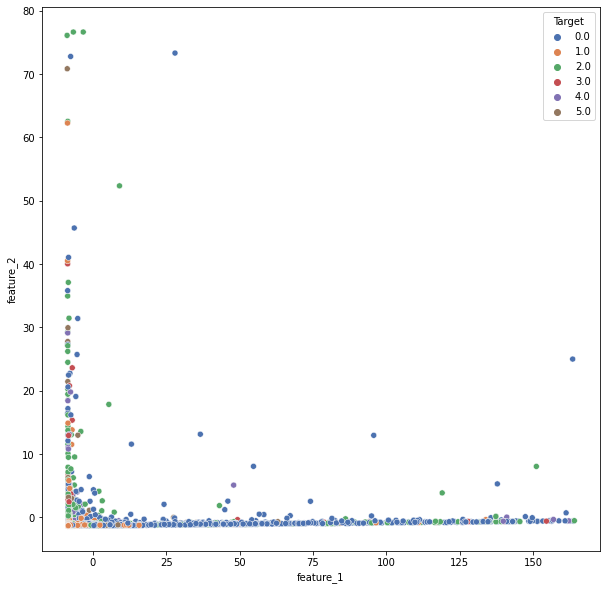

In [27]:
# Perform PCA or TSNE and plot results
n_components = 2 # Set this param here. It's used in the DBSCAN function
#data_reduced, target = dimReduction(top_10_data, type = "TSNE", n_components = n_components, n_iters = 5000, perplexity = 40)
data_reduced, target = dimReduction(top_10_data, type = "PCA", n_components = n_components)
plot_dimReduction(data_reduced, target, label_meaning = "Target", scaleFactors = [1, 1, 1])

In [9]:
# Perform PCA or TSNE and plot results
n_components = 2 # Set this param here. It's used in the DBSCAN function
data_reduced, target = dimReduction(top_10_data, type = "TSNE", n_components = n_components, n_iters = 5000, perplexity = 40)
#data_reduced, target = dimReduction(top_10_data, type = "PCA", n_components = n_components)
plot_dimReduction(data_reduced, target, label_meaning = "Target", scaleFactors = [1, 1, 1])

/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


KeyboardInterrupt: 

c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Number of Outliers Removed: 0


<ipython-input-261-d144c46bb9ba>:53: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Number of Outliers Removed: 0


<ipython-input-261-d144c46bb9ba>:53: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Number of Outliers Removed: 0


<ipython-input-261-d144c46bb9ba>:53: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Number of Outliers Removed: 0


<ipython-input-261-d144c46bb9ba>:53: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Number of Outliers Removed: 0


<ipython-input-261-d144c46bb9ba>:53: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


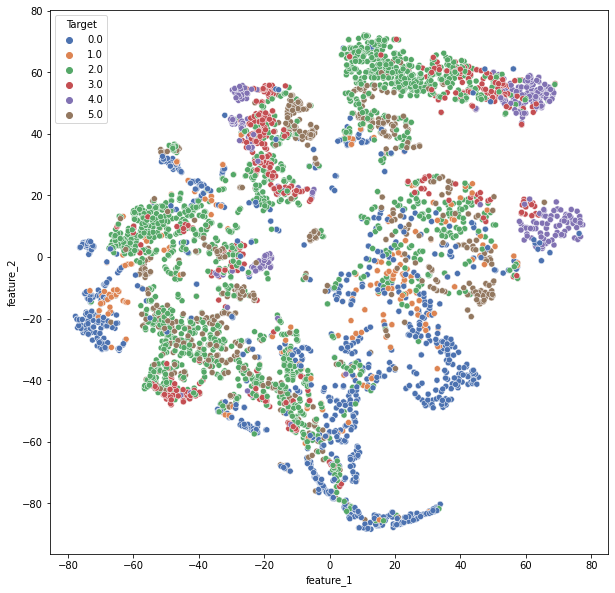

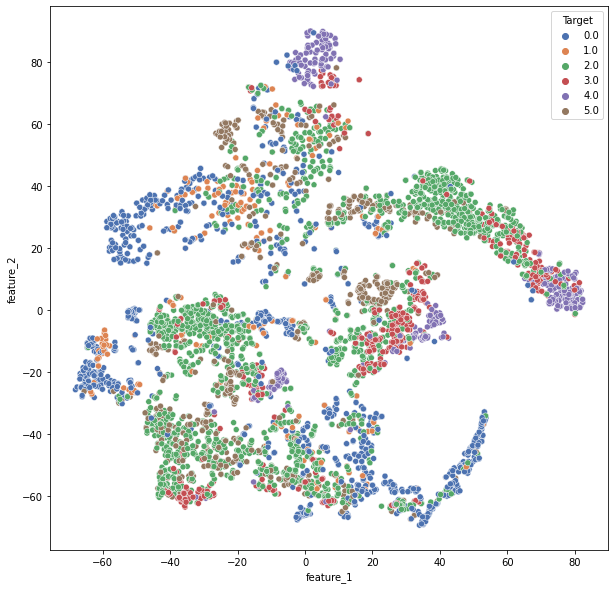

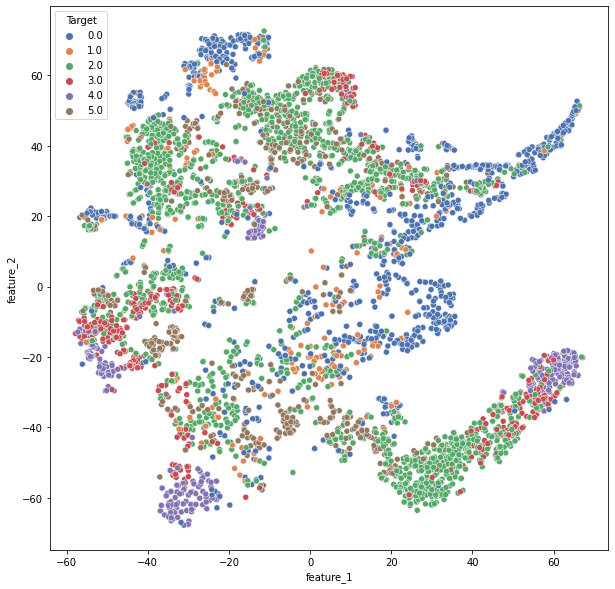

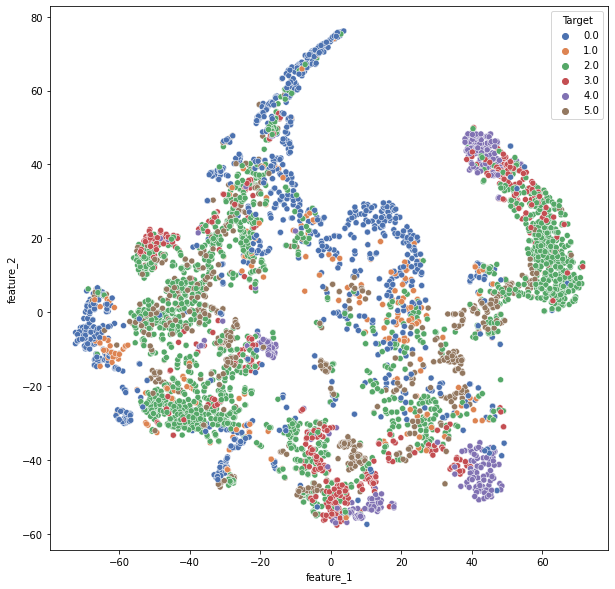

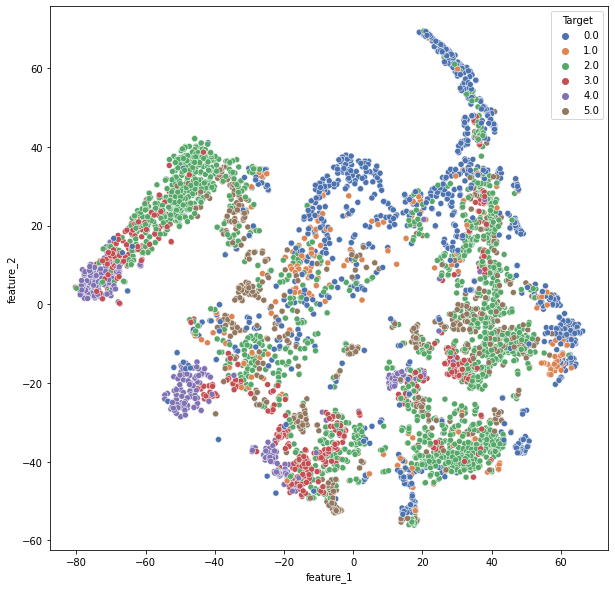

In [352]:
# Tuning TSNE:
for perplex in range(30, 55, 5):
    n_components = 2 # Set this param here. It's used in the DBSCAN function
    data_reduced, target = dimReduction(top_10_data, type = "TSNE", n_components = n_components, perplexity = perplex)
    plot_dimReduction(data_reduced, target, label_meaning = "Target", scaleFactors = [1, 1, 1])
    

In [28]:
# Define a function to assign the majority sleep stage to each cluster - this is necessary to use supervised metrics 
# comparing against target values:

def stage_for_cluster(cluster_ids, target):
    cluster_stage_assignment={}
    
    for i in set(cluster_ids):
        stage_list = pd.Series(target[cluster_ids == i])
        stage_ct = stage_list.groupby(by = stage_list).count().sort_values(ascending = False)
        stage_ct = stage_ct.reset_index()
        true_stage = stage_ct['index'][0]
        cluster_stage_assignment[i] = true_stage
        
    predicted = np.array(pd.Series(cluster_ids).map(cluster_stage_assignment))
    return predicted



In [29]:
# Get Clustering Metrics Using Cluster IDs Returned from a Clustering

def get_clustering_metrics(cluster_ids, target):
    cms={}
    predicted_labels = stage_for_cluster(cluster_ids, target)
    cms['NMI'] = metrics.normalized_mutual_info_score(target, predicted_labels)
    cms['F1'] = metrics.f1_score(target, predicted_labels, average = 'weighted')
    cms['Homogeneity'] = metrics.homogeneity_score(target, predicted_labels)
    cms['Rand Stat (Acc) (Best is 1)'] = metrics.rand_score(target, predicted_labels)
    cms['Fowlkes-Mallows (Best is 1)'] = metrics.fowlkes_mallows_score(target, predicted_labels)
    
    metric_dict = pd.concat([pd.Series(cms.keys()), pd.Series(cms.values())], axis=1)
    metric_dict.columns = ['Metric', 'Score']
    return metric_dict
    

Text(0, 0.5, '4th Nearest Neighbor')

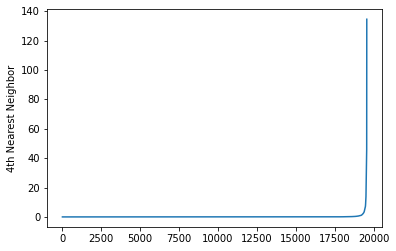

In [30]:
# Elbow Effect to Determine Eps:
n_neighbors = 4
NearestNeighborsObj = neighbors.NearestNeighbors(n_neighbors = n_neighbors)
knn = NearestNeighborsObj.fit(data_reduced)
knn_distances, _ = knn.kneighbors(data_reduced, n_neighbors = n_neighbors, return_distance = True)
kth_dist = knn_distances[:, n_neighbors - 1]
kth_dist_sorted = np.sort(kth_dist)
index = range(0, len(kth_dist))
plt.plot(index, kth_dist_sorted)
plt.ylabel('4th Nearest Neighbor')

In [31]:
kmedoids = KMedoids(n_clusters=3, random_state=0,max_iter=500).fit(data_reduced)
print(get_clustering_metrics(kmedoids.labels_,target))
kmedoids.inertia_

                        Metric     Score
0                          NMI  0.022575
1                           F1  0.237603
2                  Homogeneity  0.012542
3  Rand Stat (Acc) (Best is 1)  0.277439
4  Fowlkes-Mallows (Best is 1)  0.462061


96914.766273036

In [32]:
kmedoids.labels_

array([0, 0, 0, ..., 0, 0, 0])

Number of Outliers Removed: 902


<ipython-input-7-d144c46bb9ba>:53: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


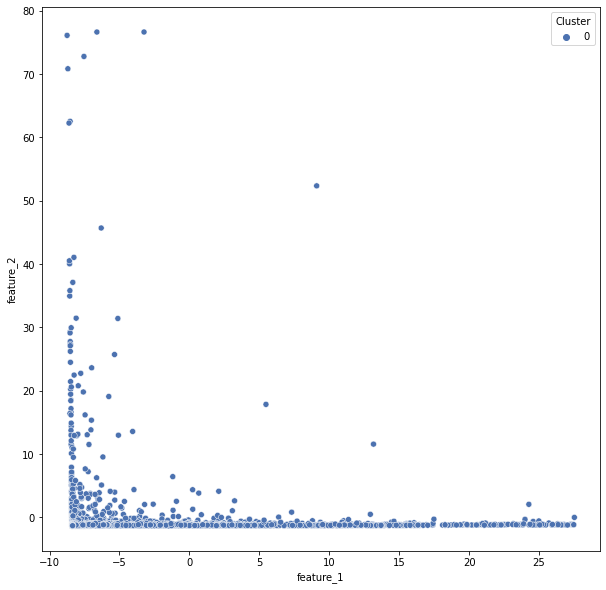

In [33]:
plot_dimReduction(data_reduced, kmedoids.labels_, label_meaning = "Cluster")

[135635.97634698392,
 135635.97634698392,
 135635.97634698392,
 135635.97634698392,
 135635.97634698392,
 135635.97634698392,
 135635.97634698392,
 135635.97634698392,
 135635.97634698392,
 135635.97634698392,
 135635.97634698392,
 135635.97634698392,
 135635.97634698392,
 135635.97634698392]

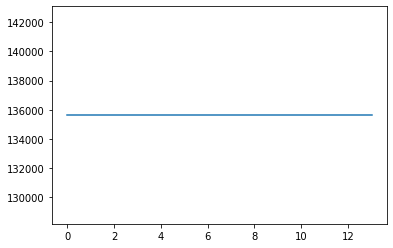

In [22]:
def find_optimal_num_clusters(max_K=15):
        losses = []
        for k in range(1, max_K):
            kmedoids = KMedoids(n_clusters=3, random_state=0,max_iter=300).fit(data_reduced)
            losses.append(kmedoids.inertia_)
        plt.plot(losses)
        return losses
    
find_optimal_num_clusters()

                        Metric     Score
0                          NMI  0.013139
1                           F1  0.219405
2                  Homogeneity  0.007111
3  Rand Stat (Acc) (Best is 1)  0.261688
4  Fowlkes-Mallows (Best is 1)  0.466633
-1       340
 0     18956
 1        21
 2         7
 3         8
 4        38
 5         7
 6       102
 7        16
 8        17
 9         9
 10        6
 11        8
 12       11
 13        7
 14        8
 15        6
dtype: int64
Number of Outliers Removed: 487


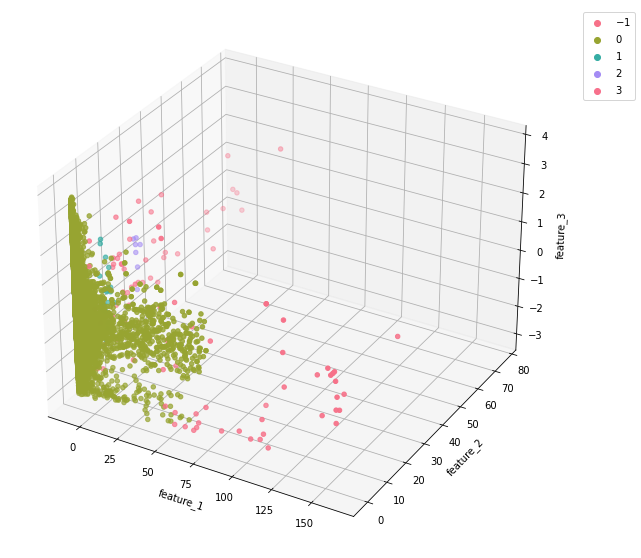

In [26]:
# DBSCAN - keep in mind the results will change each time we run PCA

dbscan = cluster.DBSCAN(eps = 1.75, min_samples = 2 * n_components)
# The choice of min_samples = 2*D (discussed in class) = 2*3 = 6. The choice of epsilon is justified in the cell below.

cluster_ids = dbscan.fit(data_reduced).labels_
print(get_clustering_metrics(cluster_ids, target))

cluster_cts = pd.Series(cluster_ids).groupby(by=cluster_ids).count()
print(cluster_cts)
# If you just get one row with -1 and 19637, need to rerun PCA

# Plot results:
plot_dimReduction(data_reduced, cluster_ids, label_meaning = "Cluster")


In [115]:
# Function Used to Determine a Good Value of Epsilon

fail_to_cluster = {}
eps_range = range(10,110) / 10 # Goes from 1 to 11 by steps of 0.1
for i in eps_range:
    num_fails = []
    for j in range(100):
        dbscan = cluster.DBSCAN(eps = i/10, min_samples = 6)
        predicted_labels = dbscan.fit(data_reduced).labels_
        cluster_cts = pd.Series(predicted_labels).groupby(by=predicted_labels).count()
        try:
            num_fails.append(cluster_cts[-1]) #DBSCAN labels given -1 if noise
        except:
            pass
    if not num_fails: # If empty (no fails in this iteration)
        num_fails = 0
    else:
        num_fails = np.array(num_fails).mean()
    fail_to_cluster[i] = num_fails

print(fail_to_cluster)

{10: 2.0, 11: 2.0, 12: 2.0, 13: 1.0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0}


<ipython-input-172-8c16b91ed672>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0', '1', '2', '3', '4', '5'])


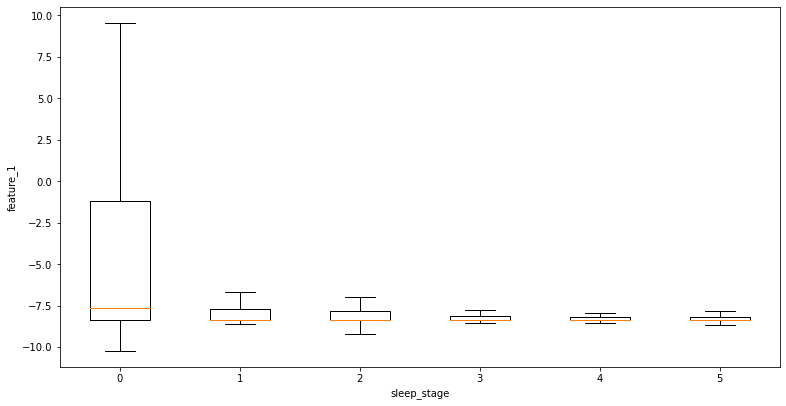

In [172]:
# 1D Plot
#sf = 10**49
sf = 1
df_reduced = pd.DataFrame(data_reduced / sf, columns=["pca_feature_1"])
df_reduced["target"] = target

# Creating dataset
np.random.seed(10)
 
data_0 = df_reduced.loc[df_reduced["target"] == 0, "pca_feature_1"]
data_1 = df_reduced.loc[df_reduced["target"] == 1, "pca_feature_1"]
data_2 = df_reduced.loc[df_reduced["target"] == 2, "pca_feature_1"]
data_3 = df_reduced.loc[df_reduced["target"] == 3, "pca_feature_1"]
data_4 = df_reduced.loc[df_reduced["target"] == 4, "pca_feature_1"]
data_5 = df_reduced.loc[df_reduced["target"] == 5, "pca_feature_1"]
data = [data_0, data_1, data_2, data_3, data_4, data_5]
 
fig = plt.figure(figsize=(10,5))
 
# Configure axes
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xticklabels(['0', '1', '2', '3', '4', '5'])
plt.xlabel("sleep_stage")
plt.ylabel("feature_1")
 
# Creating plot (handles outliers)
bp = ax.boxplot(data, showfliers=False)  

# show plot
plt.show()

Number of Outliers Removed: 59


<ipython-input-186-b1d567949e08>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


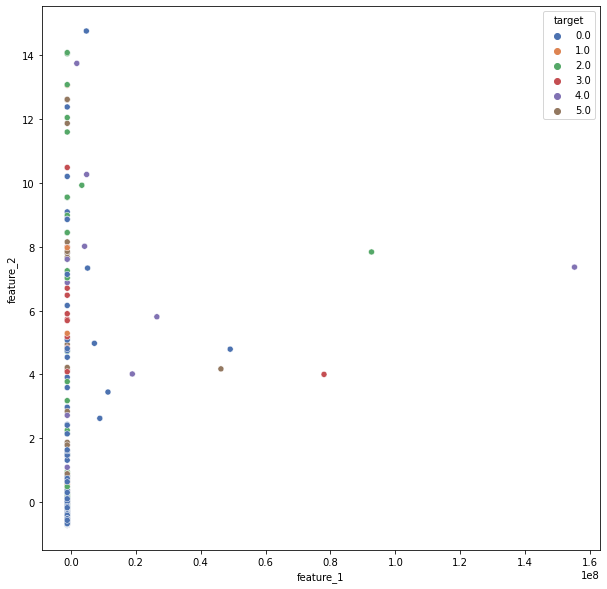

In [186]:
# Dataframe
df_reduced = pd.DataFrame(data_reduced, columns=["feature_1", "feature_2"])
df_reduced["target"] = target

# Outlier Removal
original_rows = len(df_reduced)
df_reduced = df_reduced[(np.abs(stats.zscore(df_reduced)) < 3.5).all(axis=1)]
print("Number of Outliers Removed: " + str(original_rows - len(df_reduced)))

# Optional Code to Correctly Scale/Reduce
#df_reduced = df_reduced[df_reduced["feature_1"] < 0]

# 2D Plot
fig = plt.figure(figsize=(10,10))
sns.scatterplot(data=df_reduced, x="feature_1", y="feature_2", hue="target", palette="deep")

fig.show()

Number of Outliers Removed: 300


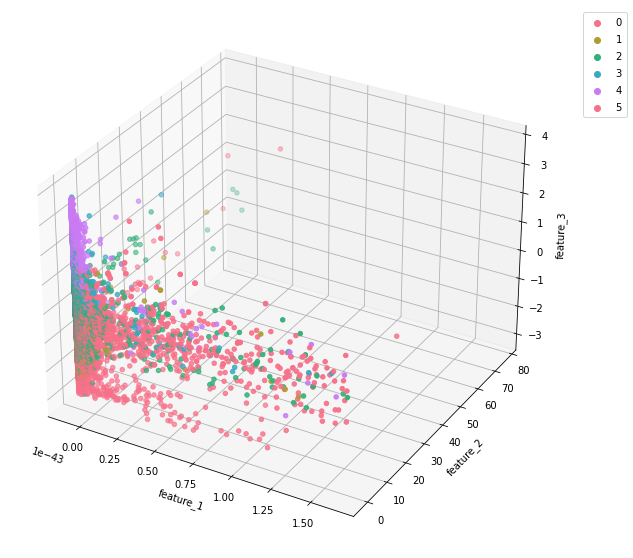

In [176]:
# Dataframe
df_reduced = pd.DataFrame(data_reduced, columns=["feature_1", "feature_2", "feature_3"])
df_reduced["target"] = target

# Outlier Removal
original_rows = len(df_reduced)
df_reduced = df_reduced[(np.abs(stats.zscore(df_reduced)) < 3.5).all(axis=1)]
print("Number of Outliers Removed: " + str(original_rows - len(df_reduced)))

# Optional Scaling Factor
# sf_x = 10**45

# 3D Plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection = '3d')
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())
try:
    sc = ax.scatter(xs=df_reduced["feature_1"] / sf_x, ys=df_reduced["feature_2"], zs=df_reduced["feature_3"], c=df_reduced["target"], cmap=cmap)
except:
    sc = ax.scatter(xs=df_reduced["feature_1"], ys=df_reduced["feature_2"], zs=df_reduced["feature_3"], c=df_reduced["target"], cmap=cmap)

# Axes
ax.set_xlabel('feature_1')
ax.set_ylabel('feature_2')
ax.set_zlabel('feature_3')

# Legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# Optional Scaling
# plt.xlim([-1.2554, -1.2548])

plt.show()